In [37]:
import sys
import numpy as np
import scipy
from scipy.stats.contingency import relative_risk
import pandas as pd
import json
import torch
import torch.nn as nn
from typing import Type
from detorch import DE, Policy, Strategy
from detorch.config import default_config, Config
import logging
import matplotlib.pyplot as plt
from math import isnan
import random

sys.path.append("..")
sys.path.append("viz")
from optimneuralts import DENeuralTSDiag, LenientDENeuralTSDiag
import viz_config

%load_ext autoreload

%autoreload 2

In [38]:
torch.set_default_tensor_type("torch.cuda.FloatTensor")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cpu = torch.device("cpu")

logging.basicConfig(level=logging.INFO)

n_dim = 150
n_trials = 2000
run_number = 0

epsilon = 0.4
inv_eps = 1 - epsilon
bounds = [0, 1]


In [39]:
logging.debug(f"Loading up this dataset: 10000r_{n_dim}c_1o_run{run_number}")

df = pd.read_csv(f"datasets/polypharmacie/10000r_{n_dim}c_1o_run{run_number}.csv")
with open(
    f"datasets/polypharmacie/10000r_{n_dim}c_1o_run{run_number}_config.json",
    "r",
) as file:
    config = json.load(file)

with open(
    f"datasets/polypharmacie/10000r_{n_dim}c_1o_run{run_number}.json", "r"
) as file:
    pattern_config = json.load(file)

pattern_codes = [
    np.array(pattern_config[f"pattern_{i}"]["code_indices"]) - 1 for i in range(10)
]

n_medical_codes = config["n_medical_codes"]
n_outcomes = config["n_outcomes"]
column_names = (
    ["patient_id"]
    + [f"medical_code_{i}" for i in range(n_medical_codes)]
    + [f"outcome_code_{i}" for i in range(n_outcomes)]
)

df.columns = column_names

X_df = df.iloc[:, 1 : n_medical_codes + 1]
X = X_df.values

y_df = df.iloc[:, n_medical_codes + 1 : n_medical_codes + 1 + n_outcomes]
y = y_df.values.ravel()

X_df.describe()
X = torch.Tensor(X)
y = torch.Tensor(y).to(cpu)
set_existing_vecs = torch.unique(X, dim=0)

logging.info(y.shape)
logging.info(X.shape)

p = torch.tensor([1 / len(set_existing_vecs)] * len(set_existing_vecs))


INFO:root:torch.Size([9999])
INFO:root:torch.Size([9999, 150])


In [40]:
class Network(nn.Module):
    def __init__(self, dim, n_hidden_layers, hidden_size=100):
        super().__init__()
        self.activation = nn.ReLU()
        self.layers = nn.ModuleList()

        self.layers.append(nn.Linear(dim, hidden_size))
        for _ in range(n_hidden_layers - 1):
            self.layers.append(nn.Linear(hidden_size, hidden_size))
        self.layers.append(nn.Linear(hidden_size, 1))

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        return self.layers[-1](x)

class PullPolicy(Policy):
    def __init__(self, eval_fn):
        super().__init__()
        idx = p.multinomial(num_samples=1).item()
        self.params = nn.Parameter(
            set_existing_vecs[idx].clone(), requires_grad=False
        )
        self.eval_fn = eval_fn
        self.ucb = None

    def evaluate(self):
        self.transform()
        ucb, activation_grad, _, _ = self.eval_fn(self.params.data)
        self.activation_grad = activation_grad
        self.ucb = ucb
        return ucb

    def transform(self):
        vec = torch.clip(self.params, *bounds).to(device)
        self.params = nn.Parameter(
            vec, requires_grad=False
        )

class DEConfig:
    n_step: int = 16
    population_size: int = 32
    differential_weight: float = 1
    crossover_probability: float = 0.9
    strategy: Strategy = Strategy.best2bin
    seed: int = 42

def risk_reward_fn(vec):
    # Determined by polypharmacy definition
    if vec.sum() < 5:
        return 0

    vec_indices = torch.where(vec == 1)[0]

    # Exposed
    rows_exposed = torch.where((X[:, vec_indices] == 1).all(axis=1))[0]
    rows_control = torch.where((X[:, vec_indices] == 0).any(axis=1))[0]
    rows_exposed_case = torch.where(y[rows_exposed] == 1)[0]
    rows_control_case = torch.where(y[rows_control] == 1)[0]

    n_exposed = len(rows_exposed)
    n_exposed_case = len(rows_exposed_case)
    n_control = len(rows_control)
    n_control_case = len(rows_control_case)
    rr = relative_risk(
        n_exposed_case, n_exposed, n_control_case, n_control
    ).relative_risk

    if isnan(rr):
        # Interpreted as 0 by experts
        return 0

    elif rr == float("inf"):
        return 10  # Return something really big, but not inf so it doesn't break the regression

    return rr

def change_to_closest_existing_vector(vec):
    dists = torch.norm(vec - set_existing_vecs, dim=1, p=1)
    knn_idx = dists.topk(1, largest=False).indices[0]
    return set_existing_vecs[knn_idx]

def gen_warmup_vecs_and_rewards(n_warmup):
    vecs = []
    rewards = []
    for i in range(n_warmup):
        idx = p.multinomial(num_samples=1).item()
        vec = set_existing_vecs[idx]
        reward = risk_reward_fn(vec)
        vecs.append(vec.tolist())
        rewards.append([reward])

    vecs = torch.tensor(vecs)
    rewards = torch.tensor(rewards)
    return vecs, rewards

def reseed_de(de_config):
    # Bypass default config of DE and modify seed so populations are different from invocation to invocation
    random.seed(os.urandom(100))
    de_config.seed = random.randint(0, 100000)

def find_best_member(agent_eval_fn, de_config):
    reseed_de(de_config)
    config = Config(default_config)

    @config("policy")
    class PolicyConfig:
        policy: Type[Policy] = PullPolicy
        eval_fn: object = agent_eval_fn
        

    config("de")(de_config)

    de = DE(config)
    de.train()

    return de.population[de.current_best]


def make_deterministic(seed=42):
    # PyTorch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    # Numpy
    np.random.seed(seed)

    # Built-in Python
    random.seed(seed)

def compute_jaccard(found_solution, true_solution):
    found_sol_list = found_solution.tolist()
    true_sol_list = true_solution.tolist()

    n_in_inter = 0

    for vec in found_sol_list:
        n_in_inter += vec in true_sol_list

    return n_in_inter / (len(found_solution) + len(true_solution) - n_in_inter), n_in_inter


In [41]:
risks = []
for vec in set_existing_vecs:
    risks.append(risk_reward_fn(vec))
risks = np.array(risks)
max_risk = max(risks)
thresh = inv_eps * max_risk
true_sol = set_existing_vecs[np.where(risks >= thresh)]
n_true_sol = len(true_sol)
logging.info(len(set_existing_vecs))
logging.info(len(true_sol))

# Find how many pattern vecs are actually in solution
pattern_vecs_in_sol = []
pattern_risks = []
vecs_with_patterns = []
for code_indices in pattern_codes:
    vec = np.zeros(n_dim)
    vec[code_indices] = 1
    vec = torch.tensor(vec)
    pattern_risk = risk_reward_fn(vec)
    if pattern_risk >= thresh:
        pattern_vecs_in_sol.append(vec)
        for existing_vec in true_sol:
            if (existing_vec[code_indices] == 1).all():
                vecs_with_patterns.append(existing_vec)

pattern_vecs_in_sol = torch.stack(pattern_vecs_in_sol).float()
vecs_with_patterns = torch.stack(vecs_with_patterns)
vecs_with_patterns = torch.unique(vecs_with_patterns, dim=0).float()

n_patterns_in_sol = len(pattern_vecs_in_sol)

logging.info(len(pattern_vecs_in_sol))
logging.info(len(vecs_with_patterns))

INFO:root:9956
INFO:root:3641
INFO:root:10
INFO:root:3252


In [42]:
width = 100
n_hidden_layers= 1
net = Network(n_dim, n_hidden_layers, width).to(device)
reg = 1
exploration_mult = 1
delay = 0
reward_fn = risk_reward_fn
de_config = DEConfig
de_policy = PullPolicy
max_n_steps = 100
lr = 1e-3

agent = DENeuralTSDiag(net, nu=exploration_mult, lamdba=reg, style="ts")
# agent = LenientDENeuralTSDiag(net, nu=exploration_mult, lamdba=reg, reward_sample_thresholds=[float('-inf'), 0])


## warmup

In [43]:
vecs, rewards = gen_warmup_vecs_and_rewards(100)

for i in range(len(rewards)):
    agent.vec_history = vecs[:i + 1]
    agent.reward_history = rewards[:i + 1]
    vec = vecs[i]
    activ, grad = agent.compute_activation_and_grad(vec)
    agent.U += grad * grad
    agent.train(min(i + 1, max_n_steps), lr)

In [44]:
hist_solution = []
hist_solution_pat = []
jaccards = []
ratio_apps = []
percent_found_pats = []
percent_found_existing_vecs_with_pats = []
hist_a_t = []
hist_r_t = []

sol = agent.find_solution_in_vecs(set_existing_vecs, thresh) # Parmis tous les vecteurs existant, lesquels je trouve ? (Jaccard, ratio_app)
sol_pat = agent.find_solution_in_vecs(pattern_vecs_in_sol, thresh) # Parmis les patrons insérés, combien j'en trouve tels quels (Ratio_p.t.)
sol_existing_vecs_with_pat = agent.find_solution_in_vecs(vecs_with_patterns, thresh) # parmis les combi qui existent dans Dataset ET ont le patron, combien je trouve (Ratio de combi ayant la patron trouvées)

jaccard, n_inter = compute_jaccard(sol, true_sol) # À quel point ma solution trouvée parmis les vecteurs du dataset est similaire à la vraie solution

percent_found_pat = len(sol_pat) / len(pattern_vecs_in_sol) # Combien de patrons tels quels j'ai flag ?
percent_found_existing_vecs_with_pat = len(sol_existing_vecs_with_pat) / len(vecs_with_patterns) # Combien de combi avec un patron dans le dataset j'ai flag?
if len(sol) == 0:
    ratio_app = 0
else:
    ratio_app = n_inter / len(sol) # A quel point ma solution trouvee parmis les vecteurs du dataset est dans la vraie solution

jaccards.append(jaccard)
ratio_apps.append(ratio_app)
percent_found_pats.append(percent_found_pat)
percent_found_existing_vecs_with_pats.append(percent_found_existing_vecs_with_pat)


logging.info(f'jaccard: {jaccard}, ratio_app: {ratio_app}, ratio of patterns found: {percent_found_pat}, ratio of existing vecs with pattern found: {percent_found_existing_vecs_with_pat}, n_inter: {n_inter}')

INFO:root:jaccard: 0.0, ratio_app: 0, ratio of patterns found: 0.0, ratio of existing vecs with pattern found: 0.0, n_inter: 0


## train

In [45]:
import time

losses = []

for i in range(n_trials):
    logging.info(f'trial: {i}')
    best_member = find_best_member(agent.get_sample, de_config)
    best_member_grad = best_member.activation_grad
    a_t = best_member.params.data
    a_t = change_to_closest_existing_vector(a_t)
    r_t = torch.tensor([reward_fn(a_t)]).unsqueeze(0)
    a_t = a_t[None,:]

    agent.U += best_member_grad * best_member_grad
    
    agent.vec_history = torch.cat((agent.vec_history, a_t))
    agent.reward_history = torch.cat((agent.reward_history, r_t))

    n_steps = min(agent.reward_history.shape[0], max_n_steps) 
    loss = agent.train(n_steps, lr)

    if (i + 1) % 100 == 0:
        losses.append(loss)
        
        sol = agent.find_solution_in_vecs(set_existing_vecs, thresh) # Parmis tous les vecteurs existant, lesquels je trouve ? (Jaccard, ratio_app)
        sol_pat = agent.find_solution_in_vecs(pattern_vecs_in_sol, thresh) # Parmis les patrons insérés, combien j'en trouve tels quels (Ratio_p.t.)
        sol_existing_vecs_with_pat = agent.find_solution_in_vecs(vecs_with_patterns, thresh) # parmis les combi qui existent dans Dataset ET ont le patron, combien je trouve (Ratio de combi ayant le patron trouvées)

        jaccard, n_inter = compute_jaccard(sol, true_sol) # À quel point ma solution trouvée parmis les vecteurs du dataset est similaire à la vraie solution
        
        percent_found_pat = len(sol_pat) / len(pattern_vecs_in_sol) # Combien de patrons tels quels j'ai flag ?
        percent_found_existing_vecs_with_pat = len(sol_existing_vecs_with_pat) / len(vecs_with_patterns) # Combien de combi avec un patron dans le dataset j'ai flag?
        if len(sol) == 0:
            ratio_app = 0
        else:
            ratio_app = n_inter / len(sol) # A quel point ma solution trouvee parmis les vecteurs du dataset est dans la vraie solution

        jaccards.append(jaccard)
        ratio_apps.append(ratio_app)
        percent_found_pats.append(percent_found_pat)
        percent_found_existing_vecs_with_pats.append(percent_found_existing_vecs_with_pat)
        losses.append(loss)

        logging.info(f'jaccard: {jaccard}, ratio_app: {ratio_app}, ratio of patterns found: {percent_found_pat}, ratio of existing vecs with pattern found: {percent_found_existing_vecs_with_pat}, n_inter: {n_inter}, loss: {loss}')



INFO:root:trial: 0
INFO:root:trial: 1
INFO:root:trial: 2
INFO:root:trial: 3
INFO:root:trial: 4
INFO:root:trial: 5
INFO:root:trial: 6
INFO:root:trial: 7
INFO:root:trial: 8
INFO:root:trial: 9
INFO:root:trial: 10
INFO:root:trial: 11
INFO:root:trial: 12
INFO:root:trial: 13
INFO:root:trial: 14
INFO:root:trial: 15
INFO:root:trial: 16
INFO:root:trial: 17
INFO:root:trial: 18
INFO:root:trial: 19
INFO:root:trial: 20
INFO:root:trial: 21
INFO:root:trial: 22
INFO:root:trial: 23
INFO:root:trial: 24
INFO:root:trial: 25
INFO:root:trial: 26
INFO:root:trial: 27
INFO:root:trial: 28
INFO:root:trial: 29
INFO:root:trial: 30
INFO:root:trial: 31
INFO:root:trial: 32
INFO:root:trial: 33
INFO:root:trial: 34
INFO:root:trial: 35
INFO:root:trial: 36
INFO:root:trial: 37
INFO:root:trial: 38
INFO:root:trial: 39
INFO:root:trial: 40
INFO:root:trial: 41
INFO:root:trial: 42
INFO:root:trial: 43
INFO:root:trial: 44
INFO:root:trial: 45
INFO:root:trial: 46
INFO:root:trial: 47
INFO:root:trial: 48
INFO:root:trial: 49
INFO:root:

In [46]:
logging.info(np.mean(times))
logging.info(np.std(times))


INFO:root:108.82563571929931
INFO:root:2.25765205396381


1000: $1.315 \pm 0.033$ per trial

100: $1.27 \pm 0.032$ per trial

10: $1.17 \pm 0.045$ per trial

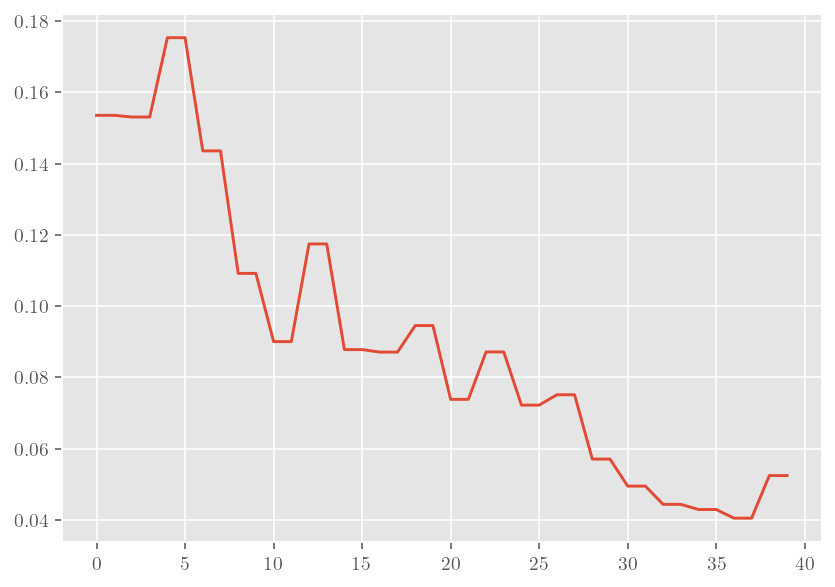

In [47]:
import matplotlib.pyplot as plt

plt.plot(list(range(len(losses))), losses)
plt.savefig(f'd150_loss_{n_trials}trials_2hidden_100steps.png')

In [48]:
path = '/home/alarouch/alarouch/neuralbandits/testing/saves'
append = f"trials{n_trials}_d{n_dim}_nlayers{n_hidden_layers}_max_n_steps_{max_n_steps}_run{run_number}"
torch.save(jaccards, f'{path}/jaccards/{append}.pth')
torch.save(ratio_apps, f'{path}/ratio_app/{append}.pth')
torch.save(percent_found_pats, f'{path}/ratio_found_pats/{append}.pth')
torch.save(percent_found_existing_vecs_with_pats, f'{path}/ratio_found_existing_vecs_with_pats/{append}.pth')
torch.save(losses, f'{path}/losses/{append}.pth')
torch.save(times, f'{path}/times/{append}.pth')

FileNotFoundError: [Errno 2] No such file or directory: '/home/alarouch/alarouch/neuralbandits/testing/saves/jaccards/trials2000_d150_nlayers1_max_n_steps_100_run0.pth'